In [ ]:
pip install pycm

     ---------------------------------------- 0.0/49.1 kB ? eta -:--:--
     ---------------------------------------- 49.1/49.1 kB 2.6 MB/s eta 0:00:00
     ---------------------------------------- 0.0/69.9 kB ? eta -:--:--
     ---------------------------------------- 69.9/69.9 kB 3.7 MB/s eta 0:00:00
   ---------------------------------------- 0.0/70.3 kB ? eta -:--:--
   ---------------------------------------- 70.3/70.3 kB ? eta 0:00:00
   ---------------------------------------- 0.0/599.8 kB ? eta -:--:--
   -------------------------- ------------- 399.4/599.8 kB 8.3 MB/s eta 0:00:01
   ---------------------------------------- 599.8/599.8 kB 9.5 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.3.1 -> 23.3.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [ ]:
import torch
import pycm
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score, classification_report
from birdclef.dataset import get_dataset, get_dataloader
from birdclef.network import get_model
import numpy as np


## Get dataset and dataloader

In [ ]:
dataset = get_dataset('test_base_per_channel')
dataloader = get_dataloader('test_base_per_channel', dataloader_kwargs={'batch_size':len(dataset), 'shuffle':False})

## Get model

In [ ]:
run_name = 'base_weighted_pcn_rnd_long'
weights_path = f'../artifacts/{run_name}.pth'

In [ ]:
import wandb

api = wandb.Api()
artifact = api.artifact(f'4projects/bird-clef-cjavelanda/{run_name}:latest', type='model')

artifact.download('../artifacts/')

wandb: Downloading large artifact base_weighted_pcn_rnd_long:latest, 79.14MB. 1 files... 
wandb:   1 of 1 files downloaded.  
Done. 0:0:0.4


'../artifacts/'

In [ ]:
model = get_model('efficient_net_v2_s', weights_path=weights_path, num_classes=dataset.num_classes)
model.load_state_dict(torch.load(f'../artifacts/{run_name}.pth'))

<All keys matched successfully>

## Run test

In [ ]:
for batch in dataloader:
    example = batch
    input, label = example['input'], example['label']
    with torch.no_grad():
        y_hat = model(input)
        y_hat = torch.argmax(torch.softmax(y_hat, dim=1), dim=1)
        print(y_hat)
    break
    

tensor([122, 197,  29,  ..., 231, 150, 160])


In [ ]:
mapping = {k:v for k,v in enumerate(dataset.classes.unique())}
sub_mapping = dict((k, mapping[k]) for k in torch.unique(torch.cat((y_hat, label))).numpy())
cm = pycm.ConfusionMatrix(actual_vector=label.numpy(), predict_vector=y_hat.numpy())
cm.relabel(mapping=sub_mapping)
# cm = confusion_matrix(label.numpy(), y_hat.numpy(), labels=range(dataset.num_classes))
cm.save_html("file_name", color=(255, 204, 255), normalize= True)
# confusion_matrix_display = ConfusionMatrixDisplay(cm, display_labels=dataset.classes.unique(), im)
# confusion_matrix_display.plot()

{'Status': True, 'Message': 'h:\\Birds\\birdclef_2023\\nbs\\file_name.html'}

In [ ]:
used_classes = torch.unique(torch.cat((y_hat, label))).numpy()
dataset_train = get_dataset('train_base_per_channel')
datas = dataset_train.classes.value_counts(sort = False).iloc[used_classes]
name_freq = np.array(list(datas.items()))
name_freq.shape
f1 = f1_score(label.numpy(), y_hat.numpy(), average= None, labels=used_classes)
f1 = np.expand_dims(f1, axis=1)
name_freq_f1 = np.concatenate((name_freq, f1), axis=1)
indices = np.argsort(name_freq_f1[:, 1].astype(float))
name_freq_f1 = name_freq_f1[indices]

(247, 2)

In [ ]:
def moving_average(data, window_size):
    """Calculate the moving average of the given data.
    
    Args:
        data: The data to calculate the moving average of.
        window_size: The size of the moving window to use.
        
    Returns:
        The moving average of the data.
    """
    return np.convolve(data, np.ones(window_size), 'valid') / window_size



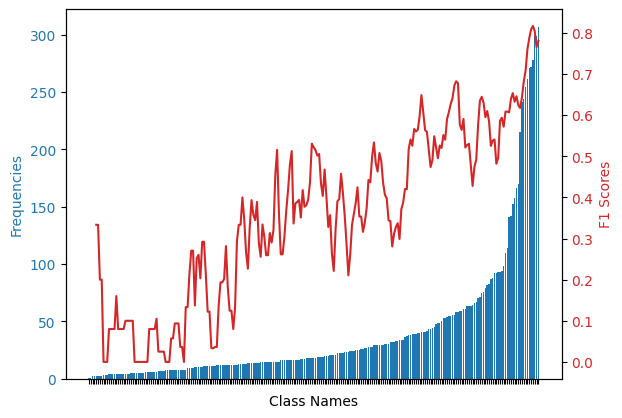

In [ ]:
import matplotlib.pyplot as plt

# Separate the names, frequencies, and f1 scores
names = name_freq_f1[:, 0]
frequencies = name_freq_f1[:, 1].astype(float)
f1_scores = name_freq_f1[:, 2].astype(float)

# Calculate the moving average of the F1 scores
smoothed_f1_scores = moving_average(f1_scores, window_size=5)

# Create a figure and a set of subplots
fig, ax1 = plt.subplots()

# Plot the frequencies
color = 'tab:blue'
ax1.set_xlabel('Class Names')
ax1.set_ylabel('Frequencies', color=color)
ax1.bar(names, frequencies, color=color)
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_xticklabels([])

# Create a second y-axis for the f1 scores
ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('F1 Scores', color=color)
ax2.plot(names[len(names) - len(smoothed_f1_scores):], smoothed_f1_scores, color=color)
ax2.tick_params(axis='y', labelcolor=color)



# Rotate x-axis labels for better visibility
plt.xticks(rotation=90)

# Show the plot
plt.show()